<div align="center">

## Positional Player Scouting

</div>

This notebook is prepared by [Hadi Sotudeh](https://www.linkedin.com/in/hadisotudeh).

### Setup

First, import the required libraries.

In [1]:
from matplotlib import rcParams
from PyPDF2 import PdfMerger
from pathlib import Path
from tqdm import tqdm
import pandas as pd
import warnings

from src.utils import substitution_condition
from src.data_parser import SkillCorner
from src.scouting import Position

# setting some configs

warnings.filterwarnings("ignore")

rcParams.update(
    {
        "font.family": "serif",
        "font.serif": ["Computer Modern Roman", "cmr10", "DejaVu Serif"],
        "mathtext.fontset": "cm",
    }
)

pd.set_option("display.max_columns", None)

The raw [SkillCorner data](https://github.com/SkillCorner/opendata) (tracking, events, phases, and dynamic events) is downloaded to the **data** folder if it is not already there, and the results are stored in the **position_maps** folder.

In [2]:
# Where to save raw data
data_dir = Path("data")
data_dir.mkdir(exist_ok=True)

# Where to save the results
position_maps_dir = Path("position_maps")
position_maps_dir.mkdir(exist_ok=True)

Here, we specify the SkillCorner match IDs to be used.

In [3]:
# SkillCorner match Ids
match_ids = [
    2017461,
    1996435,
    1886347,
    1899585,
    1925299,
    1953632,
    2006229,
    2011166,
    2013725,
    2015213,
]

We create a **skillcorner** object from the **SkillCorner** class in `src/data_parser.py` to preprocess the raw data.

In [4]:
# Create a skillcorner object to parse raw data later
skillcorner = SkillCorner()

### **Position Map** Definition:

For each in-play match tracking frame, we create a 5x5 rectangular grid around a team's outfield players, dividing it into five vertical and five horizontal channels. The horizontal axis (width) is divided into equal bands, the vertical axis (length) is divided according to weights of (0.5, 1, 1, 1, 0.5) to account for outliers.

A player's cell in this grid determines his/her instantaneous position relative to teammates.

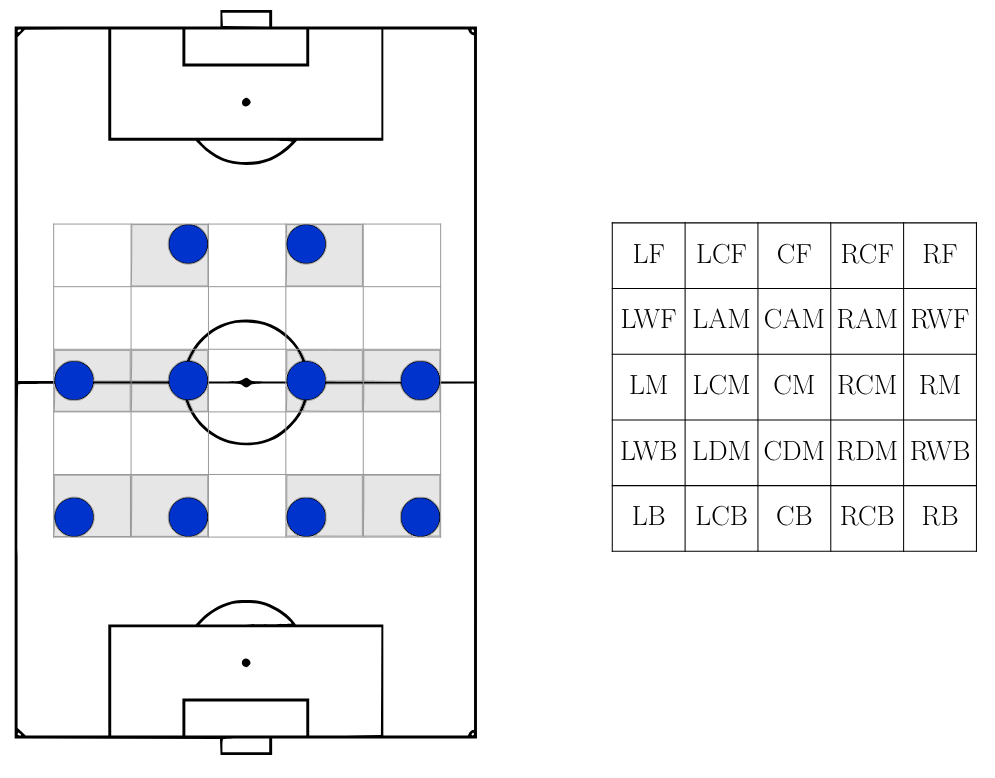

Each player's mtach-time appearance across the 25 possible positions can be summarized in a **position map**, which is a 5×5 grid where each cell shows the occupancy rate for its corresponding position.

Below, you see the position map of [Quinn MacNicol](https://transfermarkt.com/quinn-macnicol/profil/spieler/1168791), a 17-year-old Brisbane Roar player from Australia and the youngest in our dataset. He was substituted in at 66:43, he played 16.64 minutes effective time.

He occupied the LAM (Left Attacking Midfielder) position for 17.7% of the match, supporting SkillCorner’s pre-labeled AM position as a plausible choice. Notably, [FotMob](https://www.fotmob.com/matches/perth-glory-vs-brisbane-roar-fc/24yzm6#4587656:tab=lineup) listed him as a midfielder, while [Transfermarkt](https://www.transfermarkt.co.uk/brisben-roar_pert-glori/index/spielbericht/4425229) specified him as CM.

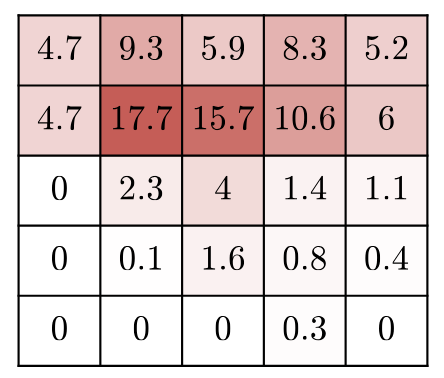

We can similarly, divide the **position maps** per phase (in possession and out of possession), see below, and subphases provided by SkillCorner (see `position_maps/players.pdf`).

### Create [SkillCorner Positions](https://skillcorner.crunch.help/en/working-with-the-data/physical-data-glossary-1-1) Templates

The next cell creates aggregated position maps for each [SkillCorner position label](https://skillcorner.crunch.help/en/working-with-the-data/physical-data-glossary-1-1) to generate the position templates.

To create the templates, we exclude last-minute substitutions (i.e., entering during the final 10 minutes). This reduces noise, as these changes often reflect match situations, such as desperation to score a goal, rather than expected position labels.

In [5]:
position_dfs_list = []

# create a position object to later create position templates
position_obj = Position(position_maps_dir)

# Iterate over available matches
for match_id in tqdm(match_ids):
    metadata_df, lineup_df, tracking_df, event_df, phases_df, gk_df = skillcorner.load(
        match_id
    )
    tracking_df = Position.assign_dynamic_positions(tracking_df)

    # Filter out players who meet the substitution condition
    tracking_df = tracking_df[
        ~tracking_df["start_time"].apply(substitution_condition)
    ].copy()

    position_dfs_list.append(tracking_df)

# Concatenate all player tracking data at once
position_dfs = pd.concat(position_dfs_list, ignore_index=True)

# Create position templates and save to position_maps_dir
position_obj.create_template(position_dfs)

  0%|          | 0/10 [00:00<?, ?it/s]

Melbourne Victory Football Club_vs_Auckland FC_2025-05-17 parsed ...


 10%|█         | 1/10 [00:11<01:42, 11.42s/it]

Sydney Football Club_vs_Adelaide United Football Club_2025-02-01 parsed ...


 20%|██        | 2/10 [00:23<01:35, 11.99s/it]

Auckland FC_vs_Newcastle United Jets FC_2024-11-30 parsed ...


 30%|███       | 3/10 [00:35<01:22, 11.72s/it]

Auckland FC_vs_Wellington Phoenix FC_2024-12-07 parsed ...


 40%|████      | 4/10 [00:45<01:07, 11.26s/it]

Brisbane Roar FC_vs_Perth Glory Football Club_2024-12-21 parsed ...


 50%|█████     | 5/10 [00:58<00:58, 11.75s/it]

Central Coast Mariners Football Club_vs_Melbourne City FC_2024-12-31 parsed ...


 60%|██████    | 6/10 [01:11<00:48, 12.20s/it]

Melbourne City FC_vs_Macarthur FC_2025-03-07 parsed ...


 70%|███████   | 7/10 [01:23<00:36, 12.27s/it]

Wellington Phoenix FC_vs_Melbourne Victory Football Club_2025-04-12 parsed ...


 80%|████████  | 8/10 [01:36<00:24, 12.46s/it]

Western United_vs_Sydney Football Club_2025-04-27 parsed ...


 90%|█████████ | 9/10 [01:49<00:12, 12.50s/it]

Western United_vs_Auckland FC_2025-05-03 parsed ...


100%|██████████| 10/10 [02:03<00:00, 12.38s/it]


### Create Player Position Maps and Compare with Templates

The next cell generates position maps for each player across phases and subphases, applies the Hellinger distance to compare them with predefined position templates, and returns the nearest neighbor classification (see `position_maps/matching.pdf`), showing 71\% agreement. 

The 3mismatches are particularly interesting, as they highlight players whose on-pitch behavior deviated from their SkillCorner tagged positions. These are potentially tactically versatile players.


In [6]:
merger = PdfMerger()  # Initialize PDF merger

# Iterate over available matches
for match_id in tqdm(match_ids):
    metadata_df, lineup_df, tracking_df, event_df, phases_df, gk_df = skillcorner.load(
        match_id
    )
    tracking_df = Position.assign_dynamic_positions(tracking_df)

    # Filter out players who meet the substitution condition
    tracking_df = tracking_df[
        ~tracking_df["start_time"].apply(substitution_condition)
    ].copy()

    merger = position_obj.plot_maps(metadata_df, lineup_df, tracking_df, merger)

# save confusion matrix
position_obj.save_nearest_neighbor_confusion_matrix()

# Save final merged PDF
output_pdf = position_maps_dir / "players.pdf"
merger.write(str(output_pdf))
merger.close()
print(f"Merged PDF saved to {output_pdf}")

  0%|          | 0/10 [00:00<?, ?it/s]

Melbourne Victory Football Club_vs_Auckland FC_2025-05-17 parsed ...


 10%|█         | 1/10 [00:49<07:29, 50.00s/it]

Sydney Football Club_vs_Adelaide United Football Club_2025-02-01 parsed ...


 20%|██        | 2/10 [01:29<05:51, 44.00s/it]

Auckland FC_vs_Newcastle United Jets FC_2024-11-30 parsed ...


 30%|███       | 3/10 [02:11<04:59, 42.80s/it]

Auckland FC_vs_Wellington Phoenix FC_2024-12-07 parsed ...


 40%|████      | 4/10 [02:50<04:08, 41.42s/it]

Brisbane Roar FC_vs_Perth Glory Football Club_2024-12-21 parsed ...


 50%|█████     | 5/10 [03:36<03:35, 43.19s/it]

Central Coast Mariners Football Club_vs_Melbourne City FC_2024-12-31 parsed ...


 60%|██████    | 6/10 [04:17<02:49, 42.31s/it]

Melbourne City FC_vs_Macarthur FC_2025-03-07 parsed ...


 70%|███████   | 7/10 [04:59<02:06, 42.19s/it]

Wellington Phoenix FC_vs_Melbourne Victory Football Club_2025-04-12 parsed ...


 80%|████████  | 8/10 [05:42<01:25, 42.56s/it]

Western United_vs_Sydney Football Club_2025-04-27 parsed ...


 90%|█████████ | 9/10 [06:24<00:42, 42.46s/it]

Western United_vs_Auckland FC_2025-05-03 parsed ...


100%|██████████| 10/10 [07:03<00:00, 42.35s/it]


Number of total cases: 267
matched
True     190
False     77
Name: count, dtype: int64
Accuracy: 71.16%
Merged PDF saved to position_maps/players.pdf


### Create 2D embedding vizualizations

Finally, we apply dimensionality reduction (e.g., MDS) to project players' position maps into a 2D space, enabling visualization and comparison of their spatial distributions. 

The following interactive Figure illustrates this, with players annotated by their SkillCorner labels and positioned according to their respective maps.


In [7]:
# Create an interactive 2D view (hover over players to see their details)
fig = position_obj.create_interactive_embedding_visualization()
fig.show()